In [0]:
import numpy as np
import sys
from os.path import join as oj
# sys.path.insert(1, oj(sys.path[0], 'train_model'))

# from train_model import sent_util

import torch
from torchtext import data, datasets

In [2]:
# set up fields
TEXT = data.Field(lower=True, include_lengths=True, batch_first=True)
LABEL = data.Field(sequential=False)

# make splits for data
train, dev, test = datasets.SST.splits(TEXT, LABEL)

# # build the vocabulary
# TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=300))
# LABEL.build_vocab(train)

# make iterator for splits
train_iter, test_iter = data.BucketIterator.splits(
    (train, test), batch_size=3, device=0)

downloading trainDevTestTrees_PTB.zip


trainDevTestTrees_PTB.zip: 100%|██████████| 790k/790k [00:02<00:00, 333kB/s]


extracting


The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [3]:
# for i in range(50):
#   print(vars(test[i]))
#   print(train[i].label)
c_neu = 0
c_neg = 0
c_pos = 0
for i in range(len(train)):
  if train[i].label is 'neutral':
    c_neu += 1
  elif train[i].label is 'positive':
    c_pos += 1
  elif train[i].label is 'negative':
    c_neg += 1
  else:
    print("error!")
print('pos: {}, neg: {}, neu:{}'.format(c_pos,c_neg,c_neu))

pos: 3610, neg: 3310, neu:1624


In [0]:
#ignore warning during training
# import warnings
# warnings.simplefilter("ignore", UserWarning)

# load all needed library
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchtext import data, datasets
import torch.nn.functional as F
import torch.optim as O
import matplotlib.pyplot as plt
from scipy import stats, integrate
import seaborn as sns
import scipy as sp
import time

In [0]:
# get arguments praser
def get_args():
    EPOCHS = 6
    USE_GPU = torch.cuda.is_available()
    EMBEDDING_DIM = 300
    HIDDEN_DIM = 128
    BATCH_SIZE = 50

    config = {
        "retrain": False,
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "gpu": "cuda:0",
        "d_embed": EMBEDDING_DIM,
        "d_hidden": HIDDEN_DIM,
        'word_vectors': "glove.6B.300d",
        "vector_cache": os.path.join(os.getcwd(), '.vector_cache/input_vectors.pt'),
        "save_path": "results",
        "dev_every": 1000,
        "save_every": 1000,
        "log_every": 1000
    }

    return config
  
# load sst dataset
def load_sst(args):
    # first create two fields for data, text and labels. Check https://github.com/pytorch/text#data for an example
    text = data.Field()
    labels = data.Field(sequential=False, unk_token=None)

    # we first build our dataset with all subtrees to build our vocab
    train, valid, test = datasets.SST.splits(
        text, labels, train_subtrees=True, filter_pred=lambda ex: ex.label != 'neutral')

    text.build_vocab(train, valid, test)
    if args["word_vectors"]:
        if os.path.isfile(args["vector_cache"]):
            text.vocab.vectors = torch.load(args["vector_cache"])
        else:
            text.vocab.load_vectors(args["word_vectors"])
            makedirs(os.path.dirname(args["vector_cache"]))
            torch.save(text.vocab.vectors, args["vector_cache"])
    labels.build_vocab(train)

    # Next we build our datasets without all subtrees
    if args["retrain"]:
        train, valid, test = datasets.SST.splits(text, labels, fine_grained=False, train_subtrees=False,
                                                filter_pred=lambda ex: ex.label != 'neutral')

    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train, valid, test), batch_size=args["batch_size"], device=args["gpu"])

    return text, labels, train_iter, valid_iter, train, valid
  
def makedirs(name):
    """helper function for python 2 and 3 to call os.makedirs()
       avoiding an error if the directory to be created already exists"""

    import os
    import errno

    try:
        os.makedirs(name)
    except OSError as ex:
        if ex.errno == errno.EEXIST and os.path.isdir(name):
            # ignore existing directory
            pass
        else:
            # a different error happened
            raise

# training the model  
def train_model(train_iter, valid_iter, valid_sst, inputs, outputs, args):
    model = LSTMSentiment(args)
    if args["word_vectors"]:
        model.embed.weight.data = inputs.vocab.vectors
        model.cuda()
    criterion = nn.CrossEntropyLoss()
    opt = O.Adam(model.parameters())

    iterations = 0
    start = time.time()
    best_dev_acc = -1
    train_iter.repeat = False
    all_break = False
    header = '  Time Epoch Iteration Progress    (%Epoch)   Loss   Dev/Loss     Accuracy  Dev/Accuracy'
    dev_log_template = ' '.join(
        '{:>6.0f},{:>5.0f},{:>9.0f},{:>5.0f}/{:<5.0f} {:>7.0f}%,{:>8.6f},{:8.6f},{:12.4f},{:12.4f}'.split(','))
    log_template = ' '.join(
        '{:>6.0f},{:>5.0f},{:>9.0f},{:>5.0f}/{:<5.0f} {:>7.0f}%,{:>8.6f},{},{:12.4f},{}'.split(','))
    makedirs(args["save_path"])
    print(header)

    for epoch in range(args["epochs"]):
        if all_break:
            break
        train_iter.init_epoch()
        n_correct, n_total = 0, 0
        for i, batch in enumerate(train_iter):
            model.train()
            opt.zero_grad()
            iterations += 1

            # forward pass
            answer = model(batch)

            # calculate accuracy of predictions in the current batch
            n_correct += (torch.max(answer, 1)
                          [1].view(batch.label.size()).data == batch.label.data).sum()
            n_total += batch.batch_size
            train_acc = 100. * n_correct / n_total

            loss = criterion(answer, batch.label)
            loss.backward()
            opt.step()

            if iterations % args["dev_every"] == 0:
                model.eval()
                valid_iter.init_epoch()
                n_dev_correct, dev_loss = 0, 0
                for dev_batch_idx, dev_batch in enumerate(valid_iter):
                    answer = model(dev_batch)
                    n_dev_correct += (torch.max(answer, 1)[1].view(
                        dev_batch.label.size()).data == dev_batch.label.data).sum()
                    dev_loss = criterion(answer, dev_batch.label)
                dev_acc = 100. * n_dev_correct / len(valid_sst)

                print(dev_log_template.format(time.time() - start,
                                              epoch, iterations, 1 +
                                              i, len(train_iter),
                                              100. * (1 + i) / len(train_iter), loss.data.item(), dev_loss.data.item(), train_acc, dev_acc))

                if dev_acc > best_dev_acc:
                    best_dev_acc = dev_acc
                    snapshot_prefix = os.path.join(
                        args["save_path"], 'best_snapshot')
                    snapshot_path = snapshot_prefix + '.pt'

                    # save model, delete previous 'best_snapshot' files
                    torch.save(model.state_dict(), snapshot_path)


            elif iterations % args["log_every"] == 0:
                # print progress message
                print(log_template.format(time.time() - start,
                                          epoch, iterations, 1 +
                                          i, len(train_iter),
                                          100. * (1 + i) / len(train_iter), loss.data[0], ' ' * 8, n_correct / n_total * 100, ' ' * 12))
    return model
  
  
def load_sst_logistic_reg(args):
    # first create two fields for data, text and labels. Check https://github.com/pytorch/text#data for an example
    text = data.Field()
    labels = data.Field(sequential=False, unk_token=None)

    # we first build our dataset with all subtrees to build our vocab
    train_v, valid_v, test_v = datasets.SST.splits(
        text, labels, train_subtrees=True, filter_pred=lambda ex: ex.label != 'neutral')

    text.build_vocab(train_v, valid_v, test_v)
    if args["word_vectors"]:
        if os.path.isfile(args["vector_cache"]):
            text.vocab.vectors = torch.load(args["vector_cache"])
        else:
            text.vocab.load_vectors(args["word_vectors"])
            makedirs(os.path.dirname(args["vector_cache"]))
            torch.save(text.vocab.vectors, args["vector_cache"])
    labels.build_vocab(train_v)

    # Next we build our datasets without all subtrees
    train, valid, test = datasets.SST.splits(text, labels, fine_grained=False, train_subtrees=True,
                                             filter_pred=lambda ex: ex.label != 'neutral')

    return train, valid, test
  
  
def logit_clf(inputs, outputs):
    args = get_args()
    args["n_embed"] = len(inputs.vocab)
    args["d_out"] = len(outputs.vocab)

    torch.cuda.set_device(-1)
    train, valid, test = load_sst_logistic_reg(args)

    vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)

    training_data = [text for text in train.text]
    training_labels = [label for label in train.label]
    validation_data = [text for text in valid.text]
    validation_labels = [label for label in valid.label]
    test_data = [text for text in test.text]
    test_labels = [label for label in test.label]


    bag_of_words = vectorizer.fit_transform(training_data)


    clf = LogisticRegression(dual=True)
    clf.fit(bag_of_words, training_labels)
    predictions = clf.predict(vectorizer.transform(validation_data))

    print(metrics.classification_report(validation_labels,
                                        predictions, target_names=["positive", "negative"]))
    print(metrics.accuracy_score(validation_labels, predictions))


    validation_vectorizer = CountVectorizer(
        tokenizer=lambda doc: doc, lowercase=False)
    validation_vectorizer.fit_transform(validation_data)
    word_coef_lookup = {feature: coef for coef, feature in zip(
        clf.coef_[0], vectorizer.get_feature_names())}
    word_validation_coef_lookup = {
        word: word_coef_lookup[word] for word in validation_vectorizer.vocabulary_ if word in word_coef_lookup}
    return clf, vectorizer

In [0]:

# initializing and training LSTM
# reference from https://github.com/clairett/pytorch-sentiment-classification


class LSTMSentiment(nn.Module):

    # def __init__(self, args):
    def __init__(self, args):
        super(LSTMSentiment, self).__init__()
        self.hidden_dim = args["d_hidden"]
        self.vocab_size = args["n_embed"]
        self.emb_dim = args["d_embed"]
        self.num_out = args["d_out"]
        self.batch_size = args["batch_size"]
        self.use_gpu = True  # config.use_gpu
        self.num_labels = 2
        self.embed = nn.Embedding(self.vocab_size, self.emb_dim)
        self.lstm = nn.LSTM(input_size=self.emb_dim,
                            hidden_size=self.hidden_dim)
        self.hidden_to_label = nn.Linear(self.hidden_dim, self.num_labels)

    def forward(self, batch):
        if self.use_gpu:
            self.hidden = (Variable(torch.zeros(1, batch.text.size()[1], self.hidden_dim).cuda()),
                           Variable(torch.zeros(1, batch.text.size()[1], self.hidden_dim).cuda()))
        else:
            self.hidden = (Variable(torch.zeros(1, batch.text.size()[1], self.hidden_dim)),
                           Variable(torch.zeros(1, batch.text.size()[1], self.hidden_dim)))

        vecs = self.embed(batch.text)
        lstm_out, self.hidden = self.lstm(vecs, self.hidden)
        logits = self.hidden_to_label(lstm_out[-1])
#         log_probs = F.log_softmax(logits)
        #     return logits, log_probs
        return logits

In [0]:
# CD 
from scipy.special import expit as sigmoid
from numpy import *


def Lsig3(y1, y2, y3):
  y1_cont = 0.5 * (sigmoid(y1 + y3) - sigmoid(y3) +
                   sigmoid(y1 + y2 + y3) - sigmoid(y2 + y3))
  y2_cont = 0.5 * (sigmoid(y2 + y3) - sigmoid(y3) +
                   sigmoid(y1 + y2 + y3) - sigmoid(y1 + y3))
  y3_cont = sigmoid(y3)
  return y1_cont, y2_cont, y3_cont


def Ltanh3(y1, y2, y3):
  y1_cont = 0.5 * (tanh(y1 + y3) - tanh(y3) +
                   tanh(y1 + y2 + y3) - tanh(y2 + y3))
  y2_cont = 0.5 * (tanh(y2 + y3) - tanh(y3) +
                   tanh(y1 + y2 + y3) - tanh(y1 + y3))
  y3_cont = tanh(y3)
  return y1_cont, y2_cont, y3_cont


def Ltanh2(y1, y2):
  y1_cont = 0.5 * (tanh(y1) + tanh(y1 + y2) - tanh(y2))
  y2_cont = 0.5 * (tanh(y2) + tanh(y2 + y1) - tanh(y1))
  return y1_cont, y2_cont

class CD:
    def __init__(self, model, inputs, clf, data, vectorizer, valid_data):
        self.model = model
        self.inputs = inputs
        self.data = data
        self.valid_data = valid_data
        self.vectorizer = vectorizer
        # self.generate_data(data)
        self.generate_dissenting(clf)
        self.clf = clf

    # def generate_data(self, data):
        # valid_data = []
        # print("generating data")
        # for d in data.items():
        #     df = d[1].text
        #     text = []
        #     # this is every batch
        #     for i in range(df.shape[1]):
        #         text = []
        #         for j in range(df[:, i].shape[0]):
        #             if int(df[j, i]) != 1:
        #                 text.append(self.inputs.vocab.itos[int(df[j, i])])
        #         valid_data.append(text)
        # self.valid_data = valid_data

    #we want to return the CD score W*hc[T]
    def context_decomp(self, batch, start, stop):

        # these are the weights and bias learnt for the gates for each layer during LSTM
        weights = self.model.lstm.state_dict()

        # refer variable names to paper and http://pytorch.org/docs/master/nn.html
        # split equally into 4 (150,300)
        Wi, Wf, Wg, Wo = np.split(weights['weight_ih_l0'].cpu().numpy(), 4, 0)
        Vi, Vf, Vg, Vo = np.split(weights['weight_hh_l0'].cpu().numpy(), 4, 0)
        # split equally into 4 (150,)
        bi, bf, bg, bo = np.split(weights['bias_ih_l0'].cpu(
        ).numpy() + weights['bias_hh_l0'].cpu().numpy(), 4)

        #word embedding model as specified in LSTMSentiment
        word_embedding = self.model.embed(batch.text)[:, 0].data.cpu().numpy()
        #T = number of time steps
        T = word_embedding.shape[0]

        #initialize beta, beta_c, gamma, gamma_c all to zeros
        #contributions of given phrase / elements outside of given phrase made to cell state
        Bc = np.zeros((T, self.model.hidden_dim))
        Gc = np.zeros((T, self.model.hidden_dim))

        #contributions of given phrase / elements outside of given phrase made to hidden state
        B = np.zeros((T, self.model.hidden_dim))
        G = np.zeros((T, self.model.hidden_dim))

        #temp variables: prev_B = B_(t-1), prev_G = G_(t-1)
        prev_B = np.zeros(self.model.hidden_dim)
        prev_G = np.zeros(self.model.hidden_dim)

        #assume we have a way of write each of the gates in eq 2 3 4 as linear sum of contributions from each of their inputs
        #recursively compute the decomposition using linearizing activation functions: see section 3.2.1
        for i in range(T):
            if i != 0:
                prev_B = B[i - 1]
                prev_G = G[i - 1]

            Bi = np.dot(Vi, prev_B)
            Bg = np.dot(Vg, prev_B)
            Bf = np.dot(Vf, prev_B)
            Bo = np.dot(Vo, prev_B)
            Gi = np.dot(Vi, prev_G)
            Gg = np.dot(Vg, prev_G)
            Gf = np.dot(Vf, prev_G)
            Go = np.dot(Vo, prev_G)

            #if the current time step is contained within the phrase, get what was let through
            if i >= start and i <= stop:
                Bi = Bi + np.dot(Wi, word_embedding[i])
                Bg = Bg + np.dot(Wg, word_embedding[i])
                Bf = Bf + np.dot(Wf, word_embedding[i])
                Bo = Bo + np.dot(Wo, word_embedding[i])

            #if the current time step is NOT contained in the phrase, get what was let though
            else:
                Gi += np.dot(Wi, word_embedding[i])
                Gg += np.dot(Wg, word_embedding[i])
                Gf += np.dot(Wf, word_embedding[i])
                Go += np.dot(Wo, word_embedding[i])

            Bi_cont, Gi_cont, bi_cont = Lsig3(Bi, Gi, bi)
            Bg_cont, Gg_cont, bg_cont = Ltanh3(Bg, Gg, bg)

            Bc[i] = Bi_cont * (Bg_cont + bg_cont) + bi_cont * Bg_cont
            Gc[i] = Gi_cont * (Bg_cont + Gg_cont + bg_cont) + \
                (Bi_cont + bi_cont) * Gg_cont

            #if the current time step is contained within the phrase
            if i >= start and i < stop:
                Bc[i] += bi_cont * bg_cont

            #if the current time step is NOT contained in the phrase
            else:
                Gc[i] += bi_cont * bg_cont

            if i != 0:
                Bf_cont, Gf_cont, bf_cont = Lsig3(Bf, Gf, bf)
                Bc[i] += (Bf_cont + bf_cont) * Bc[i - 1]
                Gc[i] += (Bf_cont + Gf_cont + bf_cont) * \
                    Gc[i - 1] + Gf_cont * Bc[i - 1]

            o = sigmoid(
                np.dot(Wo, word_embedding[i]) + np.dot(Vo, prev_B + prev_G) + bo)

            Bo_cont, Go_cont, bo_cont = Lsig3(Bo, Go, bo)
            new_Bh, new_Gh = Ltanh2(Bc[i], Gc[i])

            B[i] = o * new_Bh
            G[i] = o * new_Gh

        scores = np.dot(self.model.hidden_to_label.weight.data.cpu().numpy(), B[T - 1])
        return scores[0] - scores[1]

    def grab_phrase(self, num):
        text = []
        for i in self.data[num].text:
            text.append(self.inputs.vocab.itos[int(i)])
        return text

    def CD_word(self, num):
        res = []
        text = self.grab_phrase(num)
        for i, word in enumerate(text):
            rel_calc = self.context_decomp(self.data[num], i, i)
            print(rel_calc, word)
            res.append((rel_calc, word))
        return res

    def generate_dissenting(self, clf):
        print("generating dissenting subphrases")
        self.dissenting = [i for i, val in enumerate(clf.decision_function(
            self.vectorizer.transform(self.valid_data))) if abs(val) < 1.5]

    def splits_and_CD(self, idx):
        text = self.grab_phrase(idx)
        commas = [i for i, v in enumerate(text) if v == ","] + [len(text)]
        splits = [(0, commas[0] - 1)]
        for i in range(len(commas) - 1):
            splits.append((commas[i] + 1, commas[i + 1] - 1))
        return splits

    def CD_phrase(self, num):
        splits = self.splits_and_CD(num)
        text = self.grab_phrase(num)
        res = []
        for (i, j) in splits:
            rel_calc = self.context_decomp(self.data[num], i, j)
            phrase = " ".join(text[i:j + 1])
            print(rel_calc, phrase)
            res.append((rel_calc, phrase))
        return res

    def generate_score_tuple(self, batch, text, start, end):
        return (" ".join(text[start:end]), self.context_decomp(batch, start, end - 1))

    # CD_subphrases takes in the index and start/end of dissenting subphrase within the sentence
    # returns an array of CD score before, of the phrase itself, and after
    def CD_diss_subphrases(self, batch, start, end):
        text = []
        for i in batch.text:
            text.append(self.inputs.vocab.itos[int(i)])
        res_text = [
            self.generate_score_tuple(batch, text, 0, start),
            self.generate_score_tuple(batch, text, start, end + 1),
            self.generate_score_tuple(batch, text, end + 1, len(text))
        ]
        return res_text

    def CD_negating_subphrases(self, batch, first_start, first_end, second_start, second_end):
        text = []
        for i in batch.text:
            text.append(self.inputs.vocab.itos[int(i)])
        res_text = {
            "negation_phrase": self.generate_score_tuple(batch, text, first_start, second_end + 1),
            "negation_term": self.generate_score_tuple(batch, text, first_start, first_end),
            "negated_phrase": self.generate_score_tuple(batch, text, second_start, second_end + 1),
            "overall": self.generate_score_tuple(batch, text, 0, len(text))
        }
        return res_text



def get_batches(batch_nums, train_iterator, dev_iterator, dset='train'):
    print('getting batches...')
    data_iterator = train_iterator
    # pick data_iterator
    if dset == 'train':
        data_iterator = train_iterator
    elif dset == 'valid':
        data_iterator = dev_iterator
    
    # actually get batches
    num = 0
    batches = {}
    data_iterator.init_epoch()
    for batch_idx, batch in enumerate(data_iterator):
        if batch_idx == batch_nums[num]:
            batches[batch_idx] = batch
            num += 1

        if num == max(batch_nums):
            break
        elif num == len(batch_nums):
            print('found them all')
            break
    return batches

In [8]:
args = get_args()
torch.cuda.set_device(0)
inputs, outputs, train_iter, valid_iter, train_sst, valid_sst = load_sst(args)
args["n_embed"] = len(inputs.vocab) + 2
args["d_out"] = len(outputs.vocab)

print(args["n_embed"], args["d_out"])

.vector_cache/glove.6B.zip: 862MB [06:56, 2.07MB/s]                          
100%|█████████▉| 399504/400000 [00:42<00:00, 8923.36it/s]

20856 2


In [9]:
# We have included our pretrained model in the results folder.
# If you want to train your own model, delete or rename the file and run this cell again.

model = LSTMSentiment(args)
if os.path.isfile("best_snapshot.pt"):
    print("Loading best snapshot")
    model.cuda()
    model.load_state_dict(torch.load("best_snapshot.pt"))
else:
    model = train_model(train_iter, valid_iter, valid_sst, inputs, outputs, args)

# print("Loading best snapshot")
# model.cuda()
# model.load_state_dict(torch.load("best_snapshot.pt"))

Loading best snapshot


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [10]:
train, valid, test = load_sst_logistic_reg(args)

100%|█████████▉| 399504/400000 [01:00<00:00, 8923.36it/s]

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

# Convert a collection of text documents to a matrix of token counts
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

vectorizer = CountVectorizer(tokenizer= lambda doc:doc, lowercase=False)

training_data = [text for text in train.text]
training_labels = [label for label in train.label]
validation_data = [text for text in valid.text]
validation_labels = [label for label in valid.label]
test_data = [text for text in test.text]
test_labels = [label for label in test.label]


bag_of_words = vectorizer.fit_transform(training_data)


clf = LogisticRegression(dual=True)
clf.fit(bag_of_words, training_labels)

# Transform documents to document-term matrix.
predictions = clf.predict(vectorizer.transform(validation_data))

print(metrics.classification_report(validation_labels, predictions,target_names=["positive","negative"]))
print(metrics.accuracy_score(validation_labels, predictions))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

    positive       0.82      0.80      0.81       428
    negative       0.81      0.83      0.82       444

   micro avg       0.82      0.82      0.82       872
   macro avg       0.82      0.82      0.82       872
weighted avg       0.82      0.82      0.82       872

0.8176605504587156


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [0]:
validation_vectorizer = CountVectorizer(tokenizer = lambda doc:doc, lowercase=False)
validation_vectorizer.fit_transform(validation_data)
word_coef_lookup = {feature: coef for coef, feature in zip(clf.coef_[0], vectorizer.get_feature_names())}
word_validation_coef_lookup = {word:word_coef_lookup[word] for word in validation_vectorizer.vocabulary_ if word in word_coef_lookup}

In [0]:
args["batch_size"] = 1
args["retrain"] = True
inputs, outputs, train_iter, valid_iter, train_sst, valid_sst = load_sst(args)

In [14]:

batch_nums = list(range(len(train_iter)))
data = get_batches(batch_nums, train_iter, valid_iter, dset='train') 
cd = CD(model, inputs, clf, data, vectorizer, list(train_sst.text))

getting batches...
generating dissenting subphrases


In [15]:


good_ones = [60, 15, 16]
num = 3
print("Review level CD scores")
res_review = cd.CD_phrase(cd.dissenting[num])
print("Word level CD scores")
res_by_word = cd.CD_word(cd.dissenting[num])

Review level CD scores
-3.249974580969187 They kept much of the plot but jettisoned the stuff that would make this a moving experience for people who have n't read the book .
Word level CD scores
0.5370829804936532 They
-1.4085487087384292 kept
-0.09488223473561969 much
0.038557704579233076 of
-0.3398664904658602 the
-1.1521347096286612 plot
-0.5402037066320976 but
-0.4812590660664477 jettisoned
-0.33628420451388696 the
0.35275202972340736 stuff
-0.6921886390201286 that
-1.2189866888875058 would
-0.42063194662415526 make
-0.5612327263409091 this
0.3861473971411842 a
1.6000257679396823 moving
1.0697201080717256 experience
0.046259526500152914 for
0.02128430013459785 people
0.3897789806159863 who
-0.6887023102298286 have
-1.4748916387648927 n't
0.974383720453589 read
-0.1825364593969719 the
-0.2294518329338558 book
-0.2257859634342722 .


In [0]:
#unigram word score
# compute cd score for each word for the first time it occurs 
words = {}
if os.path.isfile("CD_SCORE_individual.csv"):
    df = pd.read_csv("CD_SCORE_individual.csv", index_col=0)
    words = {row["word"]:row["score"] for index, row in df.iterrows()} 
else:
    #Array of phrases
    for ind in range(len(data)):
        if ind%50 ==0:
            print("ind", ind)
        text = data[ind].text.data[:, 0]
        vect2Word = [inputs.vocab.itos[i] for i in text]
    #     print (vect2Word)
        for i in range(len(vect2Word)):
            if(vect2Word[i] not in words):
                words[vect2Word[i]] = cd.context_decomp(data[ind], i, i)
    df = pd.DataFrame(list(words.items()), columns=["word", "score"])
    df.to_csv("CD_SCORE_individual.csv")

In [17]:
type(word_validation_coef_lookup)
print(word_validation_coef_lookup.items())

dict_items([('It', -0.1684991139300941), ("'s", -0.12111714573089283), ('a', -0.05078870881630856), ('lovely', 2.3379199081401003), ('film', 0.4513507876935835), ('with', 0.3093705853448747), ('performances', 0.9748262936606926), ('by', -0.4270925094699829), ('Buy', 0.09594370723707525), ('and', 0.2034521850464885), ('.', -0.11300988951306404), ('And', -0.1598237430241316), ('if', 0.4813507027019175), ('you', 0.9290808068641849), ("'re", -0.3996004336753524), ('not', -2.497364593953085), ('nearly', -0.04815509054915441), ('moved', 2.901170669913698), ('to', -0.2353137272989853), ('tears', 0.3492295755437787), ('couple', 0.9854814524271736), ('of', -0.1861826863728304), ('scenes', 0.12726364327580167), (',', 0.10044594251059727), ("'ve", -0.43816891446782746), ('got', 0.7557366191814986), ('ice', -0.5953547005154657), ('water', -0.7933141208755973), ('in', -0.20948721291228334), ('your', -0.2745908196379737), ('veins', 0.19223512990061115), ('A', 0.13363077222063044), ('warm', 1.6871435

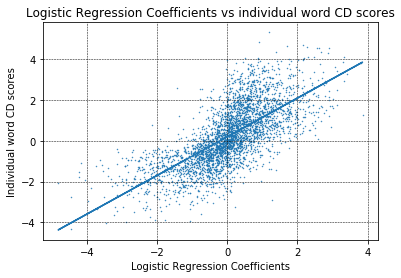

In [18]:
from sklearn.linear_model import LinearRegression

x=[]
y=[]

for key, val  in word_validation_coef_lookup.items():
    if key in words:
        x.append(word_validation_coef_lookup[key])
        y.append(words[key])
    
# print(sp.stats.pearsonr(x,y))
reg = LinearRegression().fit(np.array(x).reshape(-1,1), np.array(y).reshape(-1,1))
m = reg.coef_[0]
c = reg.intercept_
# y_10 = [y * 10 for elem in y]
plt.title("Logistic Regression Coefficients vs individual word CD scores")
plt.xlabel("Logistic Regression Coefficients")
plt.ylabel("Individual word CD scores")
# plt.plot(x , y, 'ro')
plt.scatter(x , y, s = 0.2)
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.plot(x, m*x + c)
plt.show()

In [0]:
import nltk
from nltk.tree import Tree

ROOT = 'ROOT'

negation_terms = set(['not', 'n’t', 'lacks', 'nobody', 'nor', 'nothing', 'neither', 'never', 'none', 'nowhere', 'remotely'])
parents_set = list()

trees = []
with open(os.path.expanduser('./.data/sst/trees/train.txt')) as f:
    for line in f:
        tree = Tree.fromstring(line)
        trees.append(tree)

def getNegatingSubphrases(parent, review_id, review, parent_index, tree_height):
    nodes = [{"node":node} for node in parent]
    start_index = parent_index
  
  # Get the start and end indexes for each child based off of their parent's index. 
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            end_index = len(node["node"].leaves()) + start_index
            node['start_index'] = start_index
            node['end_index'] = end_index
            start_index = end_index
      
    if len(parent.leaves()) < 10:
        if len(nodes) >= 2:
            first_child = nodes[0]['node']
            second_child = nodes[1]['node']
            first_child_first_two_words = set()
            if type(first_child) is str:
                first_child_first_two_words = set(list(first_child))
            else:
                first_child_first_two_words = set(list(first_child.leaves())[:2])
            # if the first child has some negation terms
            if first_child_first_two_words.intersection(negation_terms):
                if int(second_child.label()) in [0,1,2,3,4]:
                    parents_set.append({"review_id":review_id,"review":review, 
                                        "parent":parent, 
                                        "first_child": first_child, 
                                        "second_child":second_child, 
                                        "first_child_start_index":nodes[0]['start_index'],
                                        "first_child_end_index":nodes[0]['end_index'],
                                        "second_child_start_index": nodes[1]['start_index'],
                                        "second_child_end_index": nodes[1]['end_index'],
                                        "height":tree_height,
                                        "negation_subphrase": nodes[1]['node']
                                        })

  # keep on recursing 
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            getNegatingSubphrases(node['node'], review_id, review, node['start_index'], tree_height + 1)

for i, tree in enumerate(trees):
    getNegatingSubphrases(tree, i, tree, 0,0)

In [0]:
negative_labels = set([0,1])
positive_labels = set([3,4])

dissenting_subphrase_reviews = []
def getDissentingSubphrase(parent, review_label, review_length, review, review_id,parent_index, tree_height):
    continue_recursion = True

    nodes = [{"node":node} for node in parent]
    start_index = parent_index

    # Get the start and end indexes for each child based off of their parent's index. 
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            end_index = len(node["node"].leaves()) + start_index
            node['start_index'] = start_index
            node['end_index'] = end_index
            start_index = end_index
  
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            node_label = int(node['node'].label())
            node_length = len(node['node'].leaves())
            if ((review_label in negative_labels and node_label in positive_labels) or (review_label in positive_labels and node_label in negative_labels)):
                if (review_length / float(3)) < node_length and (review_length * 2.0 / float(3)) > node_length:
                    dissenting_subphrase_reviews.append({"review_id":review_id,
                                                       "review":review, 
                                                       "parent":parent,
                                                       "child_start_index":node['start_index'],
                                                       "child_end_index":node['end_index'],
                                                       "dissenting_subphrase": node['node'],
                                                       "height":tree_height})
   
    for node in nodes:
        if type(node['node']) is nltk.Tree:
            getDissentingSubphrase(node['node'], review_label, review_length, review, review_id, node['start_index'], tree_height+1)

for i,tree in enumerate(trees):
    getDissentingSubphrase(tree, int(tree.label()), len(tree.leaves()), tree, i, 0, 0)

In [0]:
review_lookup = {}
# This takes a while to build. Array of phrases
for ind in range(len(data)):
    text = data[ind].text.data[:, 0]
    vect2Word = tuple(inputs.vocab.itos[i] for i in text)
    review_lookup[vect2Word] = data[ind]

In [0]:
negation_subphrase_cd_scores = []
negation_subphrase_labels = [] 
for review in parents_set:
    if tuple(review["review"].leaves()) in review_lookup and review['second_child_end_index'] - review['first_child_start_index'] < 5:
#     if tuple(review["review"].leaves()) in review_lookup:
        review_vector = review_lookup[tuple(review["review"].leaves())]
        a = cd.context_decomp(review_vector, review['first_child_start_index'],review['second_child_end_index'])
        b = cd.context_decomp(review_vector, review['first_child_start_index'], review['first_child_end_index'])
        c = cd.context_decomp(review_vector, review['second_child_start_index'], review['second_child_end_index']) 
        
        score = a-(b+c)
        negation_subphrase_cd_score = score

        subphrase_label = review['negation_subphrase'].label()

        negation_subphrase_cd_scores.append(negation_subphrase_cd_score)
        negation_subphrase_labels.append(subphrase_label) 

Number of positive:75, negative:43, all:337


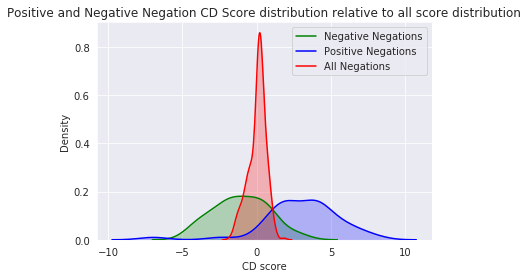

In [23]:
negative_labels = set([0,1])
positive_labels = set([3,4])

results = zip(negation_subphrase_cd_scores, negation_subphrase_labels)
positive_subphrase_cd_scores = [score for score, label in results if int(label) in [3,4]]
results = zip(negation_subphrase_cd_scores, negation_subphrase_labels)
negative_subphrase_cd_scores = [score for score, label in results if int(label) in [0,1]]
results = zip(negation_subphrase_cd_scores, negation_subphrase_labels)
all_subphrase_cd_scores = [score for score, label in results if int(label) in [0,1,2,3,4]]


x = np.asarray(positive_subphrase_cd_scores)
x2 = np.asarray(negative_subphrase_cd_scores)
x3 = np.asarray(all_subphrase_cd_scores)
print('Number of positive:{}, negative:{}, all:{}'.format(len(x),len(x2),len(x3)))
sns.set_style("darkgrid")
sns.distplot(x*1.5,hist=False, rug=False, label="Negative Negations", color="g", kde_kws={"shade": True})
sns.distplot(x2*3,hist=False, rug=False, label="Positive Negations", color="b", kde_kws={"shade": True})
sns.distplot(x3*0.5,hist=False, rug=False, label="All Negations", color="r", kde_kws={"shade": True})
plt.title('Positive and Negative Negation CD Score distribution relative to all score distribution')
plt.xlabel('CD score')
plt.ylabel('Density')
# print(len(negation_subphrase_cd_scores))
plt.legend()
plt.show()


In [24]:
print(stats.ks_2samp(x, x2))

Ks_2sampResult(statistic=0.6936434108527132, pvalue=1.7973174965774025e-12)


In [0]:
dissenting_subphrase_cd_scores = []
dissenting_subphrase_labels = []
for review in dissenting_subphrase_reviews:
  try:
    review_vector = review_lookup[tuple(review['review'].leaves())]
    dissenting_subphrase_cd_score = cd.context_decomp(review_vector, review['child_start_index'],review['child_end_index'])
    subphrase_label = review['dissenting_subphrase'].label()
    
    dissenting_subphrase_cd_scores.append(dissenting_subphrase_cd_score)
    dissenting_subphrase_labels.append(subphrase_label)
  except:
    continue

In [26]:
print(len(dissenting_subphrase_cd_scores),len(dissenting_subphrase_labels))
dissenting_subphrase_reviews[0]
review_vector

1961 1961



[torchtext.data.batch.Batch of size 1 from SST]
	[.text]:[torch.cuda.LongTensor of size 23x1 (GPU 0)]
	[.label]:[torch.cuda.LongTensor of size 1 (GPU 0)]

Number of positive:1024, negative:937


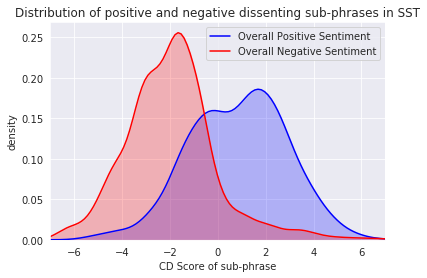

In [27]:
results = zip(dissenting_subphrase_cd_scores, dissenting_subphrase_labels)
positive_subphrase_cd_scores = [score for score, label in results if int(label) in [3,4]]
results = zip(dissenting_subphrase_cd_scores, dissenting_subphrase_labels)
negative_subphrase_cd_scores = [score for score, label in results if int(label) in [0,1]]

x = np.asarray(positive_subphrase_cd_scores)
x2 = np.asarray(negative_subphrase_cd_scores)
print('Number of positive:{}, negative:{}'.format(len(x),len(x2),))
plt.xlim(-7, 7)
sns.set_style("darkgrid")
sns.distplot(x,hist=False, rug=False, label="Overall Positive Sentiment", color="b", kde_kws={"shade": True} )
sns.distplot(x2,hist=False, rug=False, label="Overall Negative Sentiment", color="r", kde_kws={"shade": True})
plt.title("Distribution of positive and negative dissenting sub-phrases in SST")
plt.xlabel("CD Score of sub-phrase")
plt.ylabel("density")
plt.legend()
plt.show()

In [28]:
print(len(dissenting_subphrase_reviews),len(dissenting_subphrase_cd_scores))

1961 1961


In [29]:
from scipy import stats
np.random.seed(12345678)  #fix random seed to get the same result
n1 = 200  # size of first sample
n2 = 300  # size of second sample
rvs1 = stats.norm.rvs(size=n1, loc=0., scale=1)
rvs2 = stats.norm.rvs(size=n2, loc=0.5, scale=1.5)
print(stats.ks_2samp(rvs1, rvs2))
rvs3 = stats.norm.rvs(size=n2, loc=0.01, scale=1.0)
print(stats.ks_2samp(rvs1, rvs3))
rvs4 = stats.norm.rvs(size=n2, loc=0.0, scale=1.0)
print(stats.ks_2samp(rvs1, rvs4))


Ks_2sampResult(statistic=0.20833333333333337, pvalue=4.6674975515806996e-05)
Ks_2sampResult(statistic=0.10333333333333333, pvalue=0.14498781825751686)
Ks_2sampResult(statistic=0.07999999999999996, pvalue=0.4112694972985972)


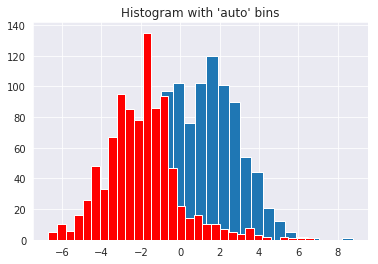

In [30]:
# x_density, _ = np.histogram(x,bins = 'auto',density=True)
# x2_density, _ = np.histogram(x2,bins = 'auto',density=True)

plt.hist(x, bins='auto')  # arguments are passed to np.histogram
plt.hist(x2, bins='auto',color = 'r')
plt.title("Histogram with 'auto' bins")
plt.show()

In [31]:
print(stats.ks_2samp(x, x2))

Ks_2sampResult(statistic=0.5896426010538954, pvalue=7.373612682898397e-150)


In [32]:
review = dissenting_subphrase_reviews[2]
data_batch = review_lookup[tuple(review["review"].leaves())]
cd.CD_diss_subphrases(data_batch, review['child_start_index'],review['child_end_index'])

[('What', 1.4819483635784514),
 ("`` Empire '' lacks in depth it", -2.858482175463056),
 ('makes up for with its heart .', 4.21944175251755)]

In [0]:
# negating_review = parents_set[1]
# negating_batch = review_lookup[tuple(negating_review["review"].leaves())]
# overall = cd.CD_negating_subphrases(negating_batch, 
#                           negating_review['first_child_start_index'], 
#                           negating_review['first_child_end_index'], 
#                           negating_review['second_child_start_index'],
#                           negating_review['second_child_end_index']
#                          )
# print("Complete review: ", overall["overall"])
# print("Overall negation: ", overall["negation_phrase"])
# print("Negation term: ", overall["negation_term"])
# print("Negated phrase: ", overall["negated_phrase"])

In [0]:
# load sst dataset
def load_sst(args):
    # first create two fields for data, text and labels. Check https://github.com/pytorch/text#data for an example
    text = data.Field(lower='preserve-case')
    labels = data.Field(sequential=False, unk_token=None)

    # we first build our dataset with all subtrees to build our vocab
    train, valid, test = datasets.SST.splits(
        text, labels, train_subtrees=True, fine_grained = False, filter_pred=lambda ex: ex.label != 'neutral')

    text.build_vocab(train, valid, test)
    if args["word_vectors"]:
        if os.path.isfile(args["vector_cache"]):
            text.vocab.vectors = torch.load(args["vector_cache"])
        else:
            text.vocab.load_vectors(args["word_vectors"])
            makedirs(os.path.dirname(args["vector_cache"]))
            torch.save(text.vocab.vectors, args["vector_cache"])
    labels.build_vocab(train)

    # Next we build our datasets without all subtrees
    if args["retrain"]:
        train, valid, test = datasets.SST.splits(text, labels, fine_grained=False, train_subtrees=False,
                                                filter_pred=lambda ex: ex.label != 'neutral')

    train_iter, valid_iter, test_iter = data.BucketIterator.splits(
        (train, valid, test), batch_size=1, device=args["gpu"])

    return text, labels, train_iter, valid_iter, train, valid
  

In [36]:
from torchtext import data, datasets

# get data
arg = get_args()
arg["retrain"] = 1
inputs, answers, train_iterator, dev_iterator,_,_ = load_sst(arg)

batch_nums = list(range(6920))
data = get_batches(batch_nums, train_iterator, dev_iterator) 
for ind in range(6919):
    text = data[ind].text.data[:, 0]
    words = [inputs.vocab.itos[i] for i in text]
    if words[0] == 'it' and words[1] == "'s" and words[2] == 'easy':
        high_level_comp_ind = ind
        break
               
# Produce CD importance scores for phrases used in figure 2
pos = cd.context_decomp(data[high_level_comp_ind], start = 0, stop = 15)
print(' '.join(words[:16]), pos)
neg = cd.context_decomp(data[high_level_comp_ind], start = 16, stop = 26)
print(' '.join(words[16:]), neg)

getting batches...
it 's easy to love robin tunney -- she 's pretty and she can act -- 1.8449944717034183
but it gets harder and harder to understand her choices . -0.6628499223167419
